2  Imports

In [1]:

import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp
from scipy import signal
import random
import os

import gesturerec.utility as grutils
import gesturerec.data as grdata
import gesturerec.gesturestream as grstream
from gesturerec.data import SensorData
from gesturerec.data import GestureSet
from gesturerec.experiments import Experiments
from gesturerec.experiments import ClassificationResults
from gesturerec.experiments import TrialClassificationResult

3  Load the data

In [2]:
# Load the data
root_gesture_log_path = './GestureLogs'

print("Found the following gesture log sub-directories")
print(grutils.get_immediate_subdirectories(root_gesture_log_path))

gesture_log_paths = grutils.get_immediate_subdirectories(root_gesture_log_path)
map_gesture_sets = dict()
selected_gesture_set = None

for gesture_log_path in gesture_log_paths:
    path_to_gesture_log = os.path.join(root_gesture_log_path, gesture_log_path)
    print("Creating a GestureSet object for path '{}'".format(path_to_gesture_log))
    gesture_set = grdata.GestureSet(path_to_gesture_log)
    gesture_set.load()
    map_gesture_sets[gesture_set.name] = gesture_set

if selected_gesture_set is None:
    #selected_gesture_set = get_random_gesture_set(map_gesture_sets)
    selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "User")
    if selected_gesture_set is None:
        # if the selected gesture set is still None
        selected_gesture_set = grdata.get_random_gesture_set(map_gesture_sets);

print("The selected gesture set:", selected_gesture_set)

Found the following gesture log sub-directories
['Test10Gesture', 'Test1Gesture', 'Test2Gesture', 'Test3Gesture', 'Test5Gesture', 'Test6Gesture', 'Test7Gesture', 'Test8Gesture', 'Test9Gesture', 'UserGesture']
Creating a GestureSet object for path './GestureLogs\Test10Gesture'
Found 30 csv files in ./GestureLogs\Test10Gesture
Found 6 gestures
Found 5 trials for 'Clockwise'
Found 5 trials for 'Counter Clockwise'
Found 5 trials for 'Down'
Found 5 trials for 'Left'
Found 5 trials for 'Right'
Found 5 trials for 'Up'
Max trial length across all gesture is 'Counter Clockwise' Trial 0 with 260 sensor events.
Avg samples/sec across 30 sensor files: 73.5
Avg sample length across 30 sensor files: 2.4s

Creating a GestureSet object for path './GestureLogs\Test1Gesture'
Found 30 csv files in ./GestureLogs\Test1Gesture
Found 6 gestures
Found 5 trials for 'Clockwise'
Found 5 trials for 'Counter Clockwise'
Found 5 trials for 'Down'
Found 5 trials for 'Left'
Found 5 trials for 'Right'
Found 5 trials fo

In [3]:
print(f"We have {len(map_gesture_sets)} gesture sets:")
for gesture_set_name, gesture_set in map_gesture_sets.items():
    print(f" {gesture_set_name} with {len(gesture_set.get_all_trials())} trials")
print(f"The selected gesture set is: {selected_gesture_set.name}")

We have 10 gesture sets:
 Test10Gesture with 30 trials
 Test1Gesture with 30 trials
 Test2Gesture with 30 trials
 Test3Gesture with 30 trials
 Test5Gesture with 30 trials
 Test6Gesture with 30 trials
 Test7Gesture with 30 trials
 Test8Gesture with 30 trials
 Test9Gesture with 30 trials
 UserGesture with 30 trials
The selected gesture set is: UserGesture


4  Preprocess the data

In [4]:
def preprocess_signal(s):
    '''Preprocesses the signal'''
    mean_filter_window_size = 5
    processed_signal = np.convolve(s, 
                                   np.ones((mean_filter_window_size,))/mean_filter_window_size, 
                                   mode='valid')
    return processed_signal

def preprocess_trial(trial):
    '''Processess the given trial'''
    trial.accel.x_p = preprocess_signal(trial.accel.x)
    trial.accel.y_p = preprocess_signal(trial.accel.y)
    trial.accel.z_p = preprocess_signal(trial.accel.z)
    trial.accel.mag_p = preprocess_signal(trial.accel.mag)

for gesture_set in map_gesture_sets.values():
    for gesture_name, trials in gesture_set.map_gestures_to_trials.items():
        for trial in trials:
            preprocess_trial(trial)

5.1  Plot a random gesture

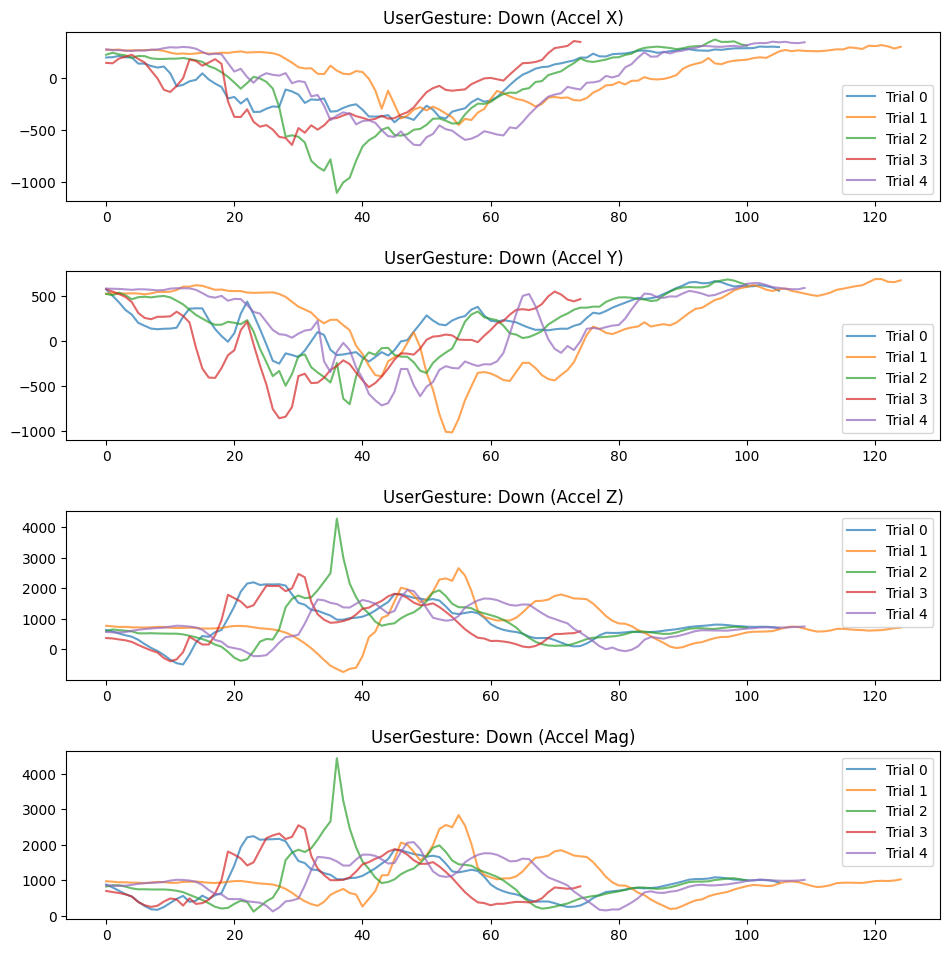

In [5]:

rand_gesture_name = selected_gesture_set.get_random_gesture_name()

fig, axes = plt.subplots(4, figsize=(10, 10)) #figsize is width, height
fig.tight_layout(pad=3) # add vertical spacing
gesture_trials = selected_gesture_set.get_trials_for_gesture(rand_gesture_name)
trial_num = 0
for trial in gesture_trials:
    axes[0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trial_num))
    axes[1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trial_num))
    axes[2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trial_num))
    axes[3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trial_num))
    trial_num = trial_num + 1

# set the title and show the legend
axes[0].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (Accel X)")
axes[0].legend();

axes[1].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (Accel Y)")
axes[1].legend();

axes[2].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (Accel Z)")
axes[2].legend();

axes[3].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (Accel Mag)")
axes[3].legend();

5.2  Plot raw and preprocessed signal

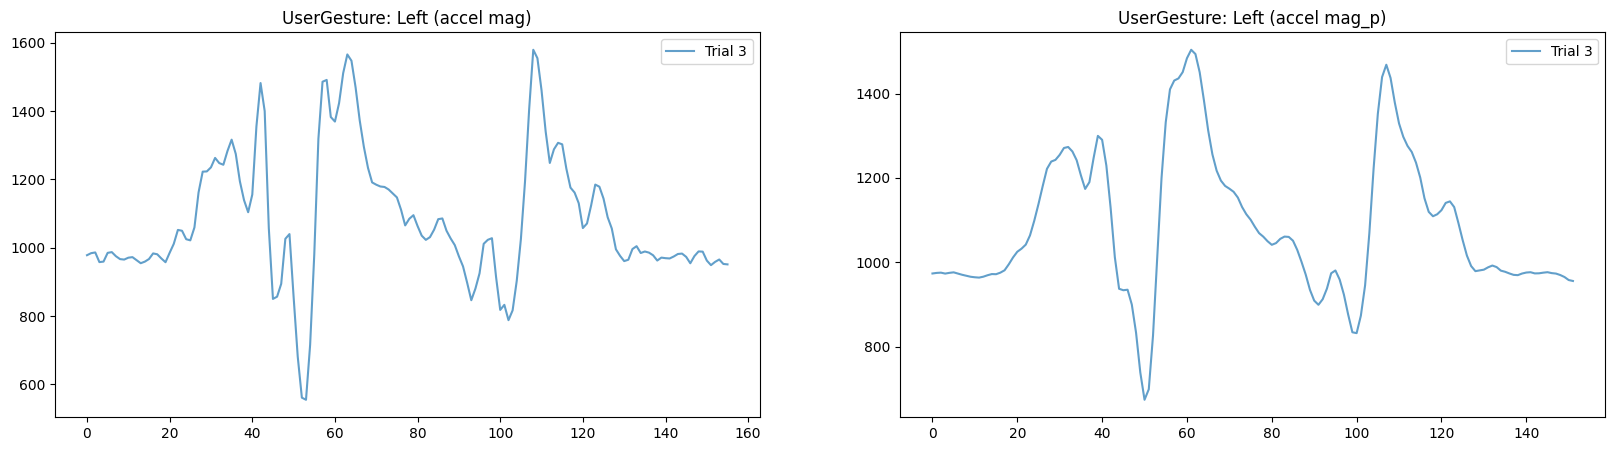

In [6]:

rand_gesture_name = selected_gesture_set.get_random_gesture_name()

# We'll make a 1x2 grid of plots, so pass 1,2 to subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 5)) #figsize is width, height
rand_trial = selected_gesture_set.get_random_trial_for_gesture(rand_gesture_name)

axes[0].plot(rand_trial.accel.mag, alpha=0.7, label="Trial {}".format(rand_trial.trial_num))
axes[0].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (accel mag)")
axes[0].legend()

axes[1].plot(rand_trial.accel.mag_p, alpha=0.7, label="Trial {}".format(rand_trial.trial_num))
axes[1].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (accel mag_p)")
axes[1].legend(); # include semi-colon to hide return output from legend(), <matplotlib.legend.Legend at 0x263de45dd30>

5.3  Plot giant grid of signals

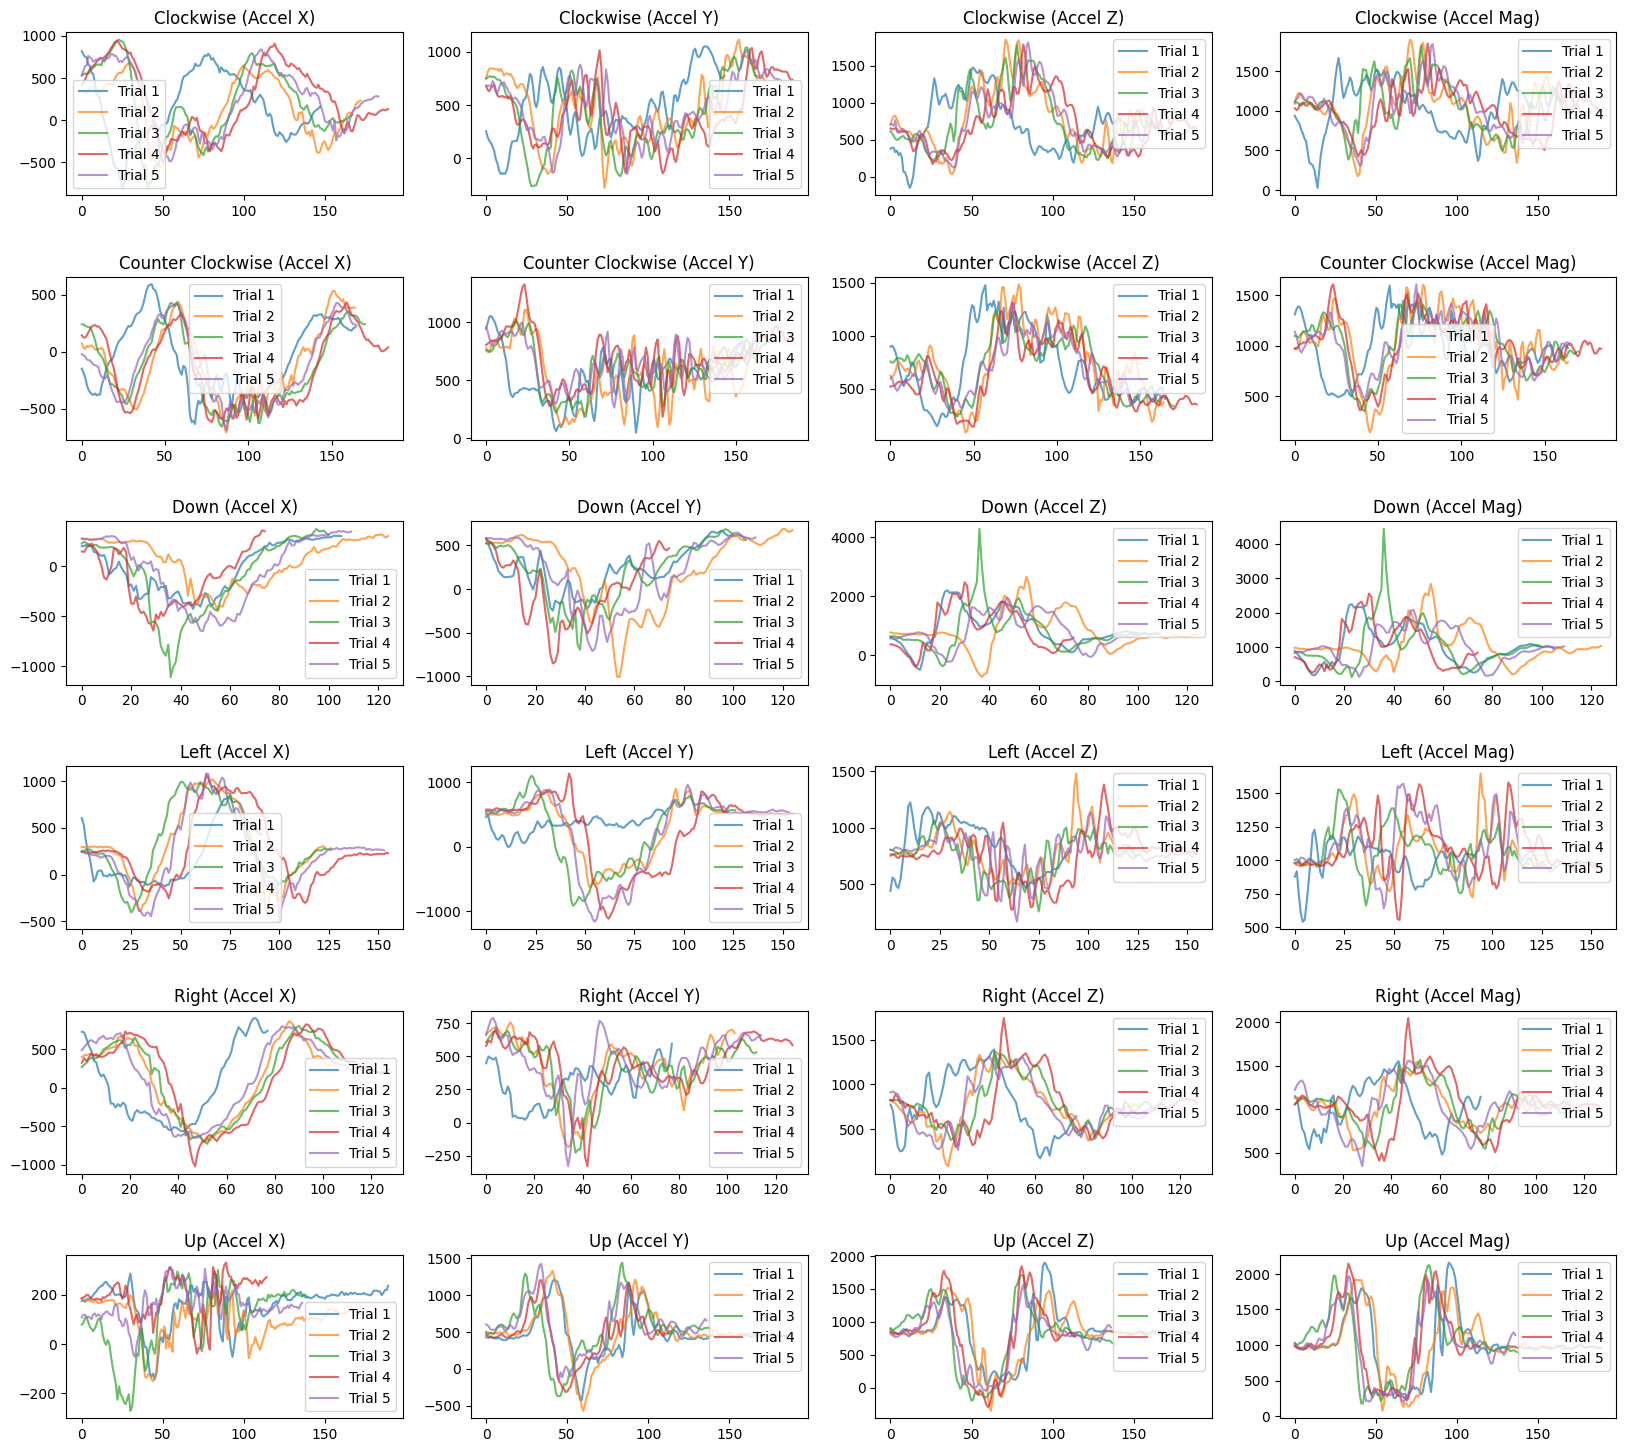

In [7]:
# make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(selected_gesture_set.map_gestures_to_trials), 4, 
                         figsize=(20, 3 * len(selected_gesture_set.map_gestures_to_trials)))
fig.subplots_adjust(hspace=0.5)

index = 0
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    gesture_trials = selected_gesture_set.get_trials_for_gesture(gesture_name)
    
    trial_num = 1
    for trial in gesture_trials:
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trial_num))
        trial_num = trial_num + 1
        
    axes[index][0].set_title(gesture_name + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gesture_name + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gesture_name + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gesture_name + " (Accel Mag)")
    axes[index][3].legend()
    index = index + 1


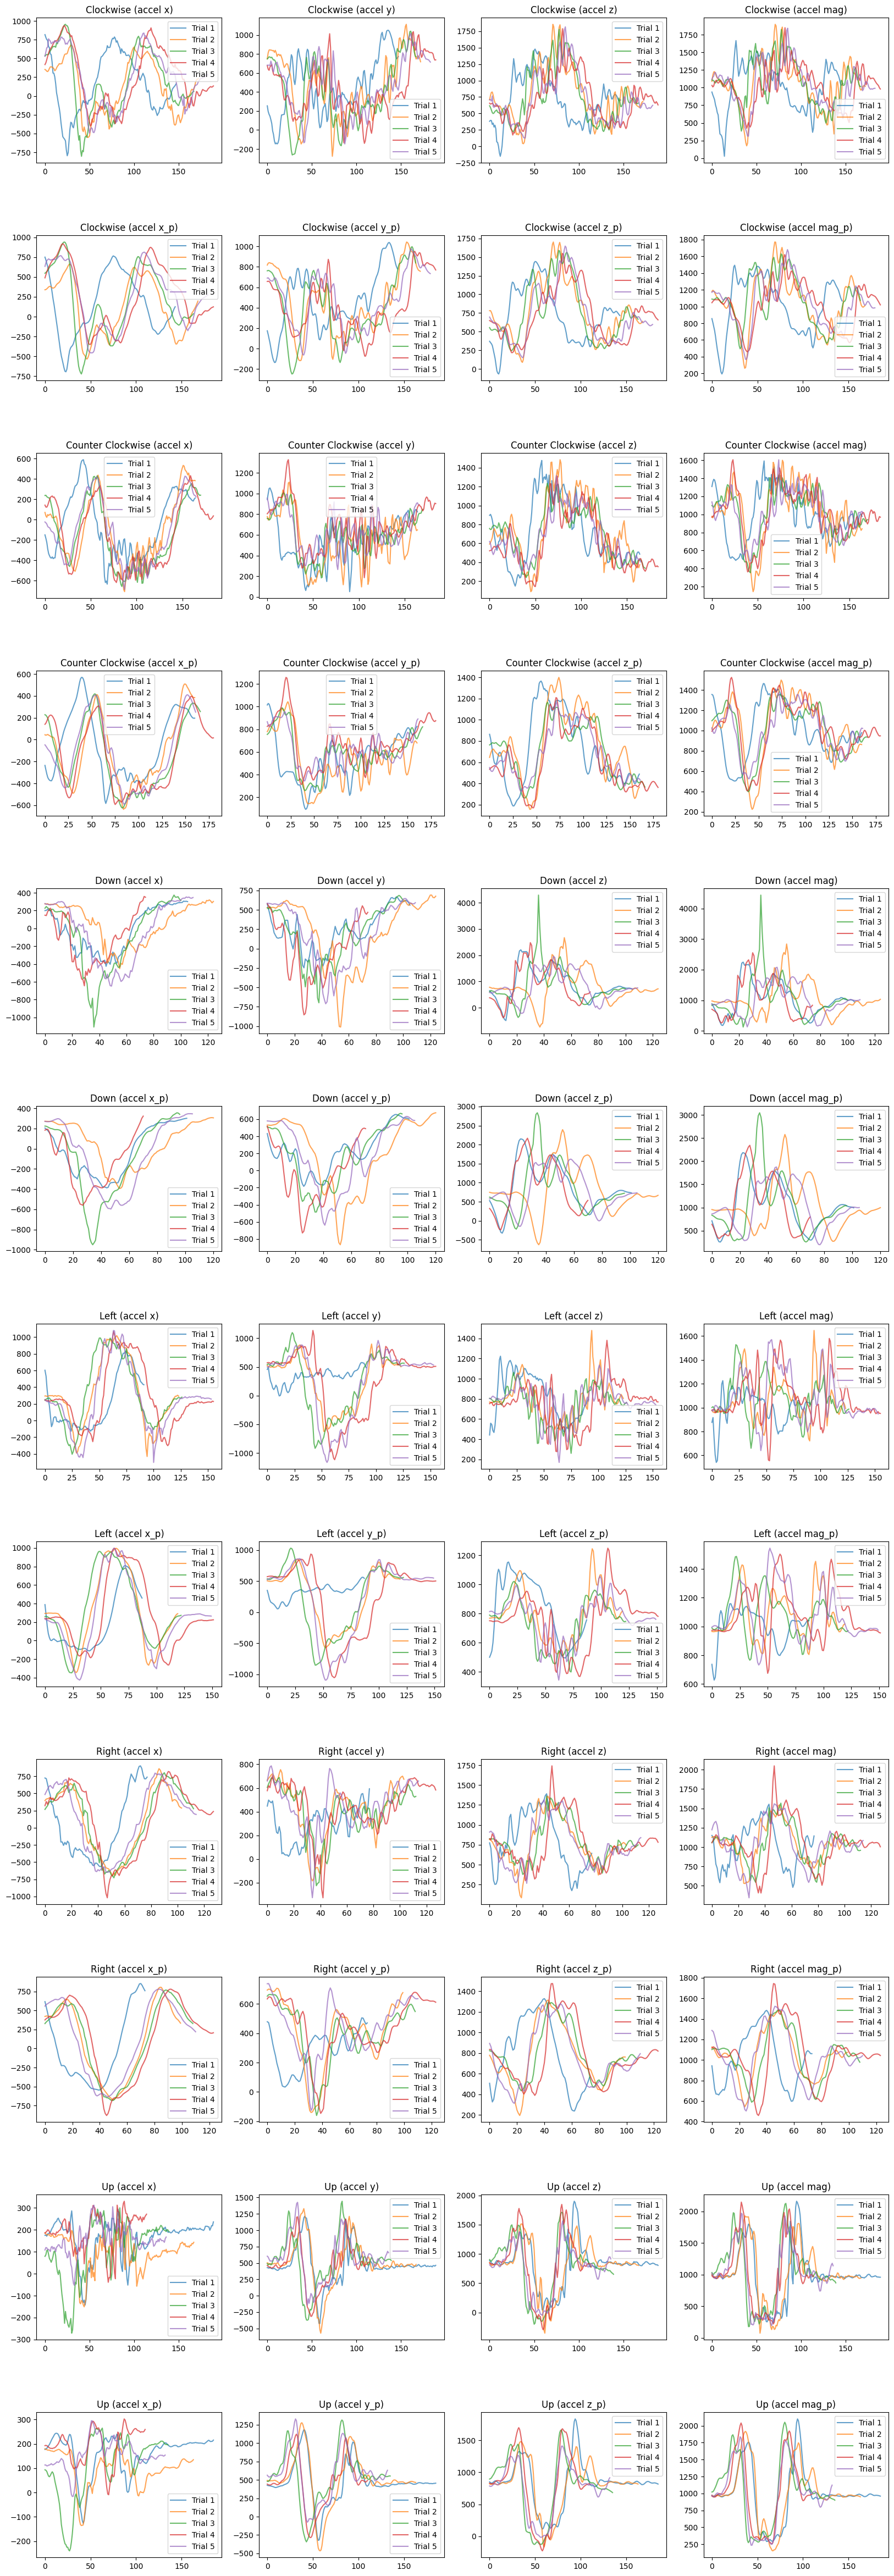

In [8]:
# make a grid of line graphs with:
# two rows for each gesture (one raw, one processed), so len(mapGestureToTrials) * 2 rows 
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(selected_gesture_set.map_gestures_to_trials) * 2, 4, 
                         figsize=(20, 5 * 2 * len(selected_gesture_set.map_gestures_to_trials)))
fig.subplots_adjust(hspace=0.5)

index = 0
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    gesture_trials = selected_gesture_set.get_trials_for_gesture(gesture_name)
    
    trial_num = 1
    for trial in gesture_trials:
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trial_num))
        
        axes[index + 1][0].plot(trial.accel.x_p, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index + 1][1].plot(trial.accel.y_p, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index + 1][2].plot(trial.accel.z_p, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index + 1][3].plot(trial.accel.mag_p, alpha=0.7, label="Trial {}".format(trial_num))
        
        trial_num = trial_num + 1
        
    axes[index][0].set_title(gesture_name + " (accel x)")
    axes[index][1].set_title(gesture_name + " (accel y)")
    axes[index][2].set_title(gesture_name + " (accel z)")
    axes[index][3].set_title(gesture_name + " (accel mag)")
    
    axes[index][0].legend()
    axes[index][1].legend()
    axes[index][2].legend()
    axes[index][3].legend()
    
    index = index + 1
    axes[index][0].set_title(gesture_name + " (accel x_p)")
    axes[index][1].set_title(gesture_name + " (accel y_p)")
    axes[index][2].set_title(gesture_name + " (accel z_p)")
    axes[index][3].set_title(gesture_name + " (accel mag_p)")
    
    axes[index][0].legend()
    axes[index][1].legend()
    axes[index][2].legend()
    axes[index][3].legend()
    
    index = index + 1

5.4  Plot raw vs preprocessed magnitude

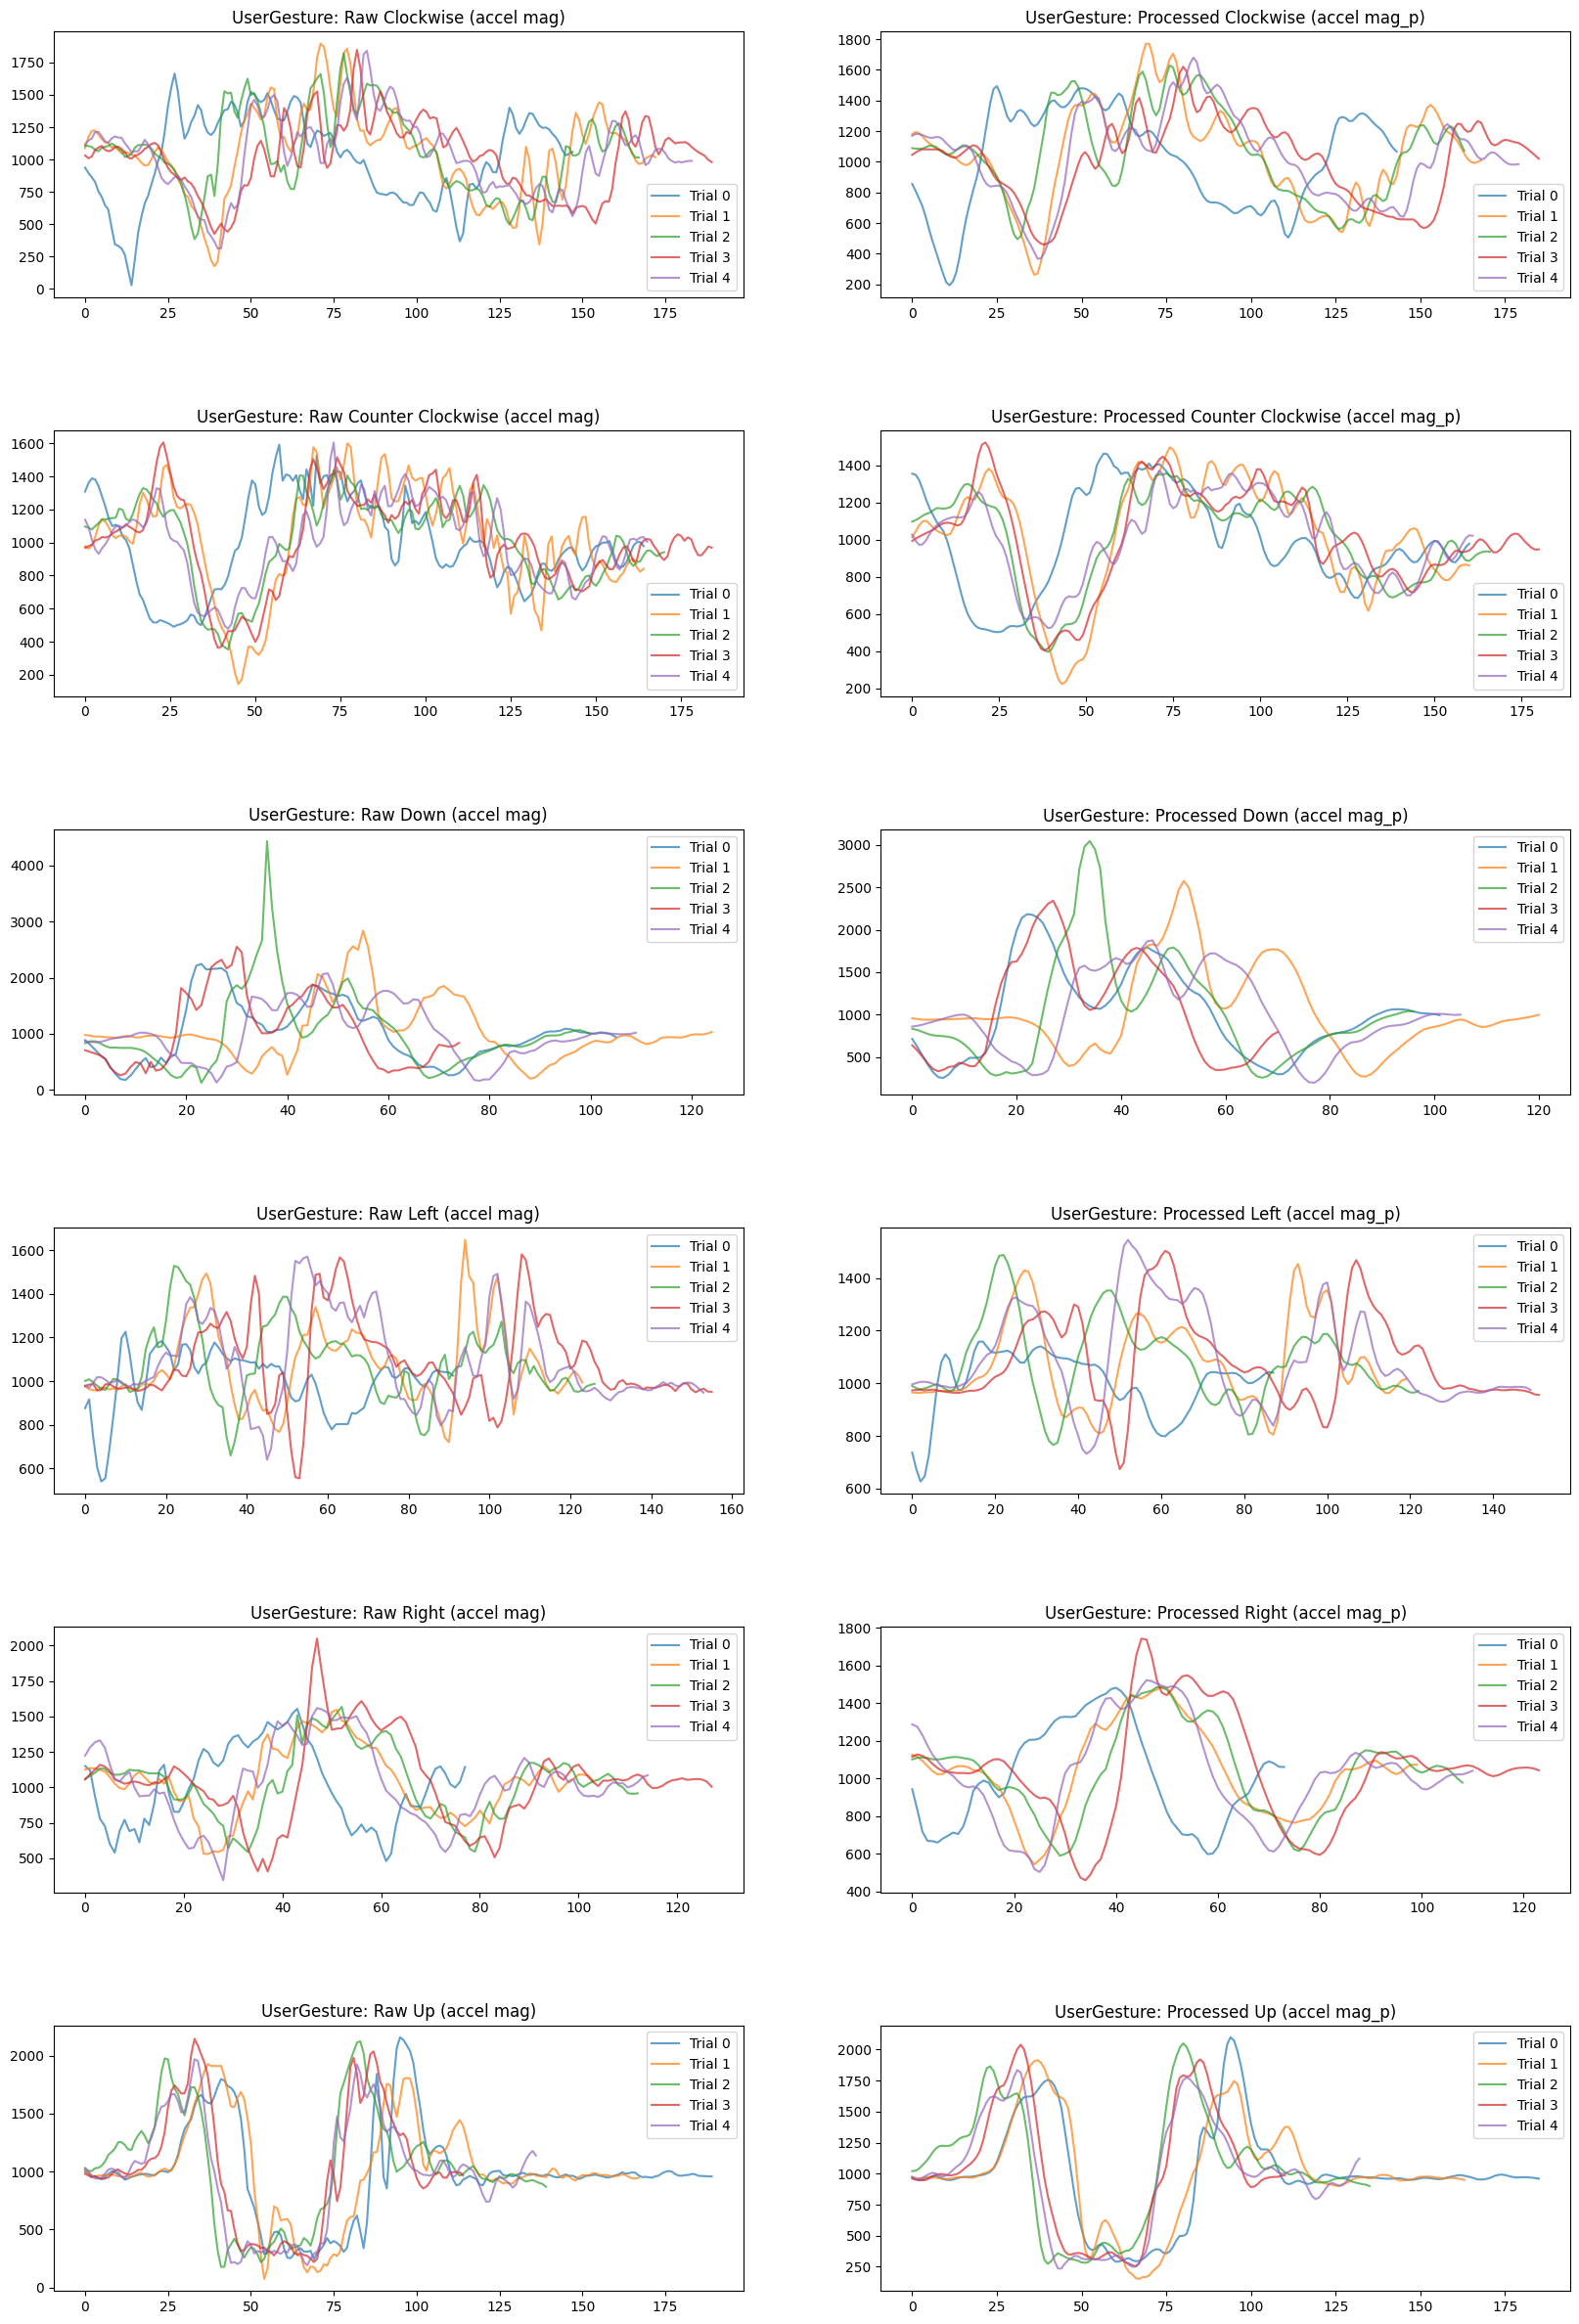

In [9]:
map_gestures_to_trials = selected_gesture_set.map_gestures_to_trials
fig, axes = plt.subplots(len(map_gestures_to_trials), 2, figsize=(20, 5 * len(map_gestures_to_trials)))
fig.subplots_adjust(hspace=0.5)

index = 0
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    gesture_trials = map_gestures_to_trials[gesture_name]
    trial_num = 0
    for trial in gesture_trials:
        axes[index][0].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index][1].plot(trial.accel.mag_p, alpha=0.7, label="Trial {}".format(trial_num))
        trial_num = trial_num + 1
        
    axes[index][0].set_title(selected_gesture_set.name + ": Raw " + gesture_name + " (accel mag)")
    axes[index][0].legend()
    
    axes[index][1].set_title(selected_gesture_set.name + ": Processed " + gesture_name + " (accel mag_p)")
    axes[index][1].legend()

    index = index + 1

6  Classification experiments

6.1  K-Fold Cross Validation Methods

In [10]:
# The k-fold cross validation methods
def generate_kfolds(num_folds, gesture_set, seed=None):
    '''
    Returns a list of folds where each list item is a dict() with key=gesture name and value=selected trial 
    for that fold. To generate the same fold structure, pass in the same seed value (this is useful for
    setting up experiments)
    
    num_folds : the number of folds
    gesture_set : the gesture set for splitting into k-folds
    seed : an integer seed value (pass in the same seed value to get the same split across multiple executions)
    '''
    
    # Quick check to make sure that there are numFolds of gesture trials for each gesture
    for gesture_name, trials in gesture_set.map_gestures_to_trials.items():
        if num_folds != len(trials):
            raise ValueError("For the purposes of this assignment, the number of folds={} must equal the number of trials for each gesture. Gesture '{}' has {} trials"
                             .format(num_folds, gesture_name, len(trials)))
            
    list_folds = [] 
    
    check_folds(list_folds)
    return list_folds


from sklearn.model_selection import StratifiedKFold
def generate_kfolds_scikit(num_folds, gesture_set, seed=None):
    '''
    Parameters:
    num_folds: the number of folds
    gesture_set: the gesture set for splitting into k-folds
    seed: an integer seed value (pass in the same seed value to get the same split across multiple executions)
    
    Returns:
    Returns a list of folds where each list item is a dict() with key=gesture name and value=selected trial 
    for that fold. To generate the same fold structure, pass in the same seed value (this is useful for
    setting up experiments). Note that even with the same seed value, this method and generate_kfolds will
    generate different results.
    '''
    
    trials = []
    trial_nums = []
    gesture_names = []
    for gesture_name, gesture_trials in map_gestures_to_trials.items():
        for trial in gesture_trials:
            trials.append(trial)
            trial_nums.append(trial.trial_num)
            gesture_names.append(gesture_name)
    
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
    
    # Iterate through the splits and setup our data structure
    fold_cnt = 0
    list_folds = list()
    for train_idx, test_idx in skf.split(trials, gesture_names):
        cur_fold_map_gesture_to_trial = dict()
        for i in test_idx:
            cur_fold_map_gesture_to_trial[gesture_names[i]] = trials[i]
        list_folds.append(cur_fold_map_gesture_to_trial)    
        fold_cnt += 1
    return list_folds

def print_folds(list_folds):
    '''
    Prints out the folds (useful for debugging)
    '''
    # print out folds (for debugging)
    fold_index = 0
    if fold_index == 0:
        for fold in list_folds:
            print("Fold: ", fold_index)
            for gesture_name, trial in fold.items():
                print("\t{} Trial: {}".format(gesture_name, trial.trial_num))
            fold_index = fold_index + 1
            
def check_folds(folds):
    '''
    Checks to see that the folds are appropriately setup (useful for debugging)
    Throw an exception if there appears to be a problem
    '''
    for test_fold_idx in range(0, len(folds)):
        # check to make sure test data is not in training data
        for test_gesture, test_trial in folds[test_fold_idx].items():
            # search for this test_gesture and trial_num in all other folds
            # it shouldn't be there!
            for train_fold_idx in range(0, len(folds)):
                if test_fold_idx != train_fold_idx:
                    for train_gesture, train_trial in folds[train_fold_idx].items():
                        if test_gesture == train_gesture and test_trial.trial_num == train_trial.trial_num:
                            raise Exception("Uh oh, gesture '{}' trial '{}' was found in both test fold '{}' and\
                                             training fold '{}.' Training folds should not include test data".format(
                                            test_gesture, test_trial.trial_num, test_fold_idx, train_fold_idx))

6.2  The matching algorithms

In [11]:
from scipy.spatial import distance
import time

def run_matching_algorithm(list_folds, find_closest_match_alg, **kwargs):
    '''
    Our primary matching algorithm function that takes in a fold, a matching algorithm, and optional 
    arguments (**kwargs) for that matching alg. Returns a ClassificationResults object
    
    list_folds : the folds generated by generate_kfolds
    find_closest_match_alg : "pointer" to the closest match function you want to test
    kwargs : optional arguments to pass to find_closest_match_alg
    '''
    
    verbose = False
    if 'verbose' in kwargs:
        verbose = kwargs['verbose']
    
    fold_index = 0
    map_gesture_name_to_list_results = dict()
    for fold in list_folds:
        if verbose:
            print("\n**FOLD: {}**".format(fold_index))
            
        correctness_cnt_for_fold = 0
        elapsed_time_for_fold = 0
        for test_gesture_name, test_trial in fold.items():
            template_folds = list_folds[0:fold_index] + list_folds[fold_index + 1:len(list_folds)]
            template_trials = list()
            for fold in template_folds:
                for template_gesture_name, template_trial in fold.items():
                    template_trials.append(template_trial)
            
            start_time = time.time()
            trial_classification_result = find_closest_match_alg(test_trial, template_trials, **kwargs)
            elapsed_time_in_secs = time.time() - start_time
            trial_classification_result.fold_idx = fold_index
            trial_classification_result.elapsed_time = elapsed_time_in_secs
            elapsed_time_for_fold += elapsed_time_in_secs
            
            if trial_classification_result.is_correct:
                correctness_cnt_for_fold += 1
            
            if verbose:
                print(trial_classification_result)
            
            # track overall results across comparisons
            if test_gesture_name not in map_gesture_name_to_list_results:
                map_gesture_name_to_list_results[test_gesture_name] = list()
            map_gesture_name_to_list_results[test_gesture_name].append(trial_classification_result)
            
        # print out overall fold accuracy
        fold_accuracy = (correctness_cnt_for_fold / len(fold)) * 100;
        if verbose:
            print("COMPLETED FOLD: {} IN {:0.3f} SECS WITH ACCURACY {}/{} ({:0.1f}%)".
                  format(fold_index, elapsed_time_for_fold, correctness_cnt_for_fold, len(fold), fold_accuracy))

        fold_index = fold_index + 1
    
    classification_result = ClassificationResults(find_closest_match_alg.__name__, 
                                                  map_gesture_name_to_list_results, **kwargs)
    return classification_result

6.2.1  Write your matching algorithms here

In [12]:
def find_closest_match_euclid_raw_x(test_trial, template_trials, **kwargs):
    '''
    run_matching_algorithm(list_folds, find_closest_match_euclid_raw_x, verbose=True)
    
    Parameters:
    test_trial: the test trial
    template_trials: the template trials
    kwargs: optional arguments for match function
    
    Returns a TrialClassificationResult
    '''
    
    # Tuple list of trial to score
    n_best_list_tuple = list()
    for template_trial in template_trials:
        
        # Euclidean distance requires that both arrays are the same length, so we must pad the shorter one
        test_trial_signal = test_trial.accel.x
        template_trial_signal = template_trial.accel.x
        if len(test_trial_signal) > len(template_trial_signal):
            array_length_diff = len(test_trial_signal) - len(template_trial_signal)
            template_trial_signal = np.pad(template_trial_signal, (0, array_length_diff), 'mean')
        elif len(template_trial_signal) > len(test_trial_signal):
            array_length_diff = len(template_trial_signal) - len(test_trial_signal)
            test_trial_signal = np.pad(test_trial_signal, (0, array_length_diff), 'mean')
        
        # Calculate the Euclidean distance between the two signals
        euclid_distance = distance.euclidean(test_trial_signal, template_trial_signal)

        n_best_list_tuple.append((template_trial, euclid_distance))
    
    trial_classification_result = TrialClassificationResult(test_trial, n_best_list_tuple) 
    
    return trial_classification_result

def find_closest_match_euclid_signal(test_trial, template_trials, **kwargs):
    '''
    run_matching_algorithm(list_folds, find_closest_match_euclid_signal, verbose=True, signal_var_name='x')
    run_matching_algorithm(list_folds, find_closest_match_euclid_signal, verbose=True, signal_var_name='y')
    
    Parameters:
    test_trial: the test trial
    template_trials: the template trials
    kwargs: one required argument for match function
        signal_var_name must be specified and is the member variable of SensorData used for 
        the test (e.g., x, y, z, mag, x_p, y_p, z_p, mag_p )
    
    Returns a TrialClassificationResult
    '''
    
    if 'signal_var_name' not in kwargs:
        raise Exception("The 'signal_var_name' kwarg must be specified. For example, \"signal_var_name='x'\"") 
   
    signal_var_name = kwargs['signal_var_name']
    
    # Tuple list of trial to score
    n_best_list_tuple = list()
    for template_trial in template_trials:
        
        # Euclidean distance requires that both arrays are the same length, so we must pad the shorter one
        test_trial_signal = getattr(test_trial.accel, signal_var_name)
        template_trial_signal = getattr(template_trial.accel, signal_var_name)
        if len(test_trial_signal) > len(template_trial_signal):
            array_length_diff = len(test_trial_signal) - len(template_trial_signal)
            template_trial_signal = np.pad(template_trial_signal, (0, array_length_diff), 'mean')
        elif len(template_trial_signal) > len(test_trial_signal):
            array_length_diff = len(template_trial_signal) - len(test_trial_signal)
            test_trial_signal = np.pad(test_trial_signal, (0, array_length_diff), 'mean')
        
        # Calculate the Euclidean distance between the two signals
        euclid_distance = distance.euclidean(test_trial_signal, template_trial_signal)

        n_best_list_tuple.append((template_trial, euclid_distance))
    
    trial_classification_result = TrialClassificationResult(test_trial, n_best_list_tuple) 
    
    return trial_classification_result
def find_closest_match_dtw(test_trial, template_trials, **kwargs):
    print("Implement this")
    
def find_closest_match_your_alg_here(test_trial, template_trials, **kwargs):
    print("Implement this too")

In [18]:

list_folds = generate_kfolds_scikit(5, gesture_set, seed=5) 

# print out folds (for debugging)
print("DEBUG: PRINTING OUT FOLDS")
print_folds(list_folds)

# track multiple experiments
experiments = Experiments()

# run initial experiment
results_x = run_matching_algorithm(list_folds, find_closest_match_euclid_raw_x, verbose=True)
results_x.title = "{}: Euclidean distance with raw x signal".format(gesture_set.name)
results_x.print_result()

experiments.add(results_x)
# run second experiment 
results_y = run_matching_algorithm(list_folds, find_closest_match_euclid_signal, verbose=True, signal_var_name='y')
results_y.title = "{}: Euclidean distance with raw y signal".format(gesture_set.name)
results_y.print_result()

experiments.add(results_y)

# run third experiment 
results_z = run_matching_algorithm(list_folds, find_closest_match_euclid_signal, verbose=True, signal_var_name='z')
results_z.title = "{}: Euclidean distance with raw z signal".format(gesture_set.name)
results_z.print_result()
experiments.add(results_z)

results_mag = run_matching_algorithm(list_folds, find_closest_match_euclid_signal, verbose=True, signal_var_name='mag')
results_mag.title = "{}: Euclidean distance with raw mag signal".format(gesture_set.name)
results_mag.print_result()
experiments.add(results_mag)

DEBUG: PRINTING OUT FOLDS
Fold:  0
	Clockwise Trial: 1
	Counter Clockwise Trial: 4
	Down Trial: 3
	Left Trial: 0
	Right Trial: 4
	Up Trial: 1
Fold:  1
	Clockwise Trial: 2
	Counter Clockwise Trial: 3
	Down Trial: 0
	Left Trial: 2
	Right Trial: 1
	Up Trial: 3
Fold:  2
	Clockwise Trial: 3
	Counter Clockwise Trial: 1
	Down Trial: 2
	Left Trial: 1
	Right Trial: 0
	Up Trial: 2
Fold:  3
	Clockwise Trial: 4
	Counter Clockwise Trial: 0
	Down Trial: 4
	Left Trial: 3
	Right Trial: 3
	Up Trial: 4
Fold:  4
	Clockwise Trial: 0
	Counter Clockwise Trial: 2
	Down Trial: 1
	Left Trial: 4
	Right Trial: 2
	Up Trial: 0

**FOLD: 0**
Incorrect : Best match for 'Clockwise' Trial 1 is 'Down' Trial 1 w/score: 3165.6 (0.015s)
Correct : Best match for 'Counter Clockwise' Trial 4 is 'Counter Clockwise' Trial 2 w/score: 1966.9 (0.003s)
Correct : Best match for 'Down' Trial 3 is 'Down' Trial 0 w/score: 2623.0 (0.004s)
Incorrect : Best match for 'Left' Trial 0 is 'Up' Trial 4 w/score: 2976.5 (0.004s)
Correct : Best m

7  Visualizing Experiment Results

In [19]:
import itertools
from sklearn.metrics import confusion_matrix
from matplotlib.lines import Line2D

def plot_bar_graph_average_scores_by_gesture(classification_results):
    correct_score_means = []
    incorrect_score_means = []
    gesture_names = classification_results.get_gesture_names()
    for gesture_name in gesture_names:
        scores_correct_matches = np.array(classification_results.get_correct_match_scores_for_gesture(gesture_name))
        scores_incorrect_matches = np.array(classification_results.get_incorrect_match_scores_for_gesture(gesture_name))

        if len(scores_correct_matches) > 0:
            correct_score_means.append(np.mean(scores_correct_matches))
        else:
            correct_score_means.append(0)
        
        if len(scores_incorrect_matches) > 0:
            incorrect_score_means.append(np.mean(scores_incorrect_matches))
        else:
            incorrect_score_means.append(0)

    # create plot
    fig, ax = plt.subplots(figsize=(12, 5))
    index = np.arange(len(gesture_names))
    bar_width = 0.35
    opacity = 0.8

    bars_correct = plt.bar(index, correct_score_means, bar_width, alpha=opacity, color='b', label='Correct')
    bars_incorrect = plt.bar(index + bar_width, incorrect_score_means, bar_width, alpha=opacity, color='g', label='Incorrect')

    plt.xlabel('Gesture')
    plt.ylabel('Average Scores')
    plt.title('Average Scores By Gesture and Correctness\n' + classification_results.get_title())
    plt.xticks(index - bar_width, gesture_names, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def plot_bar_graph_average_nbestlist_location_by_gesture(classification_results):
    '''
    Plots the average n-best list location for each gesture
    '''
    avg_nbestlist_location = []
    gesture_names = classification_results.get_gesture_names()

    for gesture_name in gesture_names:
        correct_match_indices_in_nbestlist = np.array(classification_results.get_correct_match_indices_in_nbestlist_for_gesture(gesture_name))
        avg_nbestlist_location.append(np.mean(correct_match_indices_in_nbestlist))

    # create plot
    fig, ax = plt.subplots(figsize=(12, 5))
    index = np.arange(len(gesture_names))
    # bar_width = 0.35
    opacity = 0.8

    bars_correct = plt.bar(index, avg_nbestlist_location, alpha=opacity, color='b', label='Avg NBest List Location')

    plt.xlabel('Gesture')
    plt.ylabel('Average NBest List Location')
    plt.title('Average NBest List Location By Gesture\n' + classification_results.get_title())
    plt.xticks(index, gesture_names, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def plot_classification_result_as_confusion_matrix(classification_result, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Code based on:
      - http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    See also
      - https://stackoverflow.com/a/35572520
      - Plotting with matshow: https://matplotlib.org/gallery/images_contours_and_fields/matshow.html#sphx-glr-gallery-images-contours-and-fields-matshow-py
    """
    cm = classification_result.get_confusion_matrix()
    classes = classification_result.get_gesture_names()
    plot_confusion_matrix(cm, classes, classification_result.get_title(), normalize, cmap)
    
def plot_confusion_matrix(cm, classes, title, normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")

    # print(cm)
    plt.figure(figsize=(12, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap) #imshow displays data on a 2D raster
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_bar_graph_overall_performance(experiments):
    '''
    Plots a bar graph of overall performance
    experiments : an Experiments object
    '''
    
    list_experiments = experiments.get_experiments_sorted_by_accuracy();
    n_groups = len(list_experiments)

    experiment_names = [] 
    experiment_accuracies = [] 
    for experiment in list_experiments:
        experiment_names.append(experiment.title)
        experiment_accuracies.append(experiment.get_accuracy())

    # create plot
    fig_height = max(n_groups * 0.5, 5)
    fig, ax = plt.subplots(figsize=(12, fig_height))
    index = np.arange(len(experiment_names))
    # bar_width = 0.35
    opacity = 0.8

    plt.grid(zorder=0)
    bars = plt.barh(index, experiment_accuracies, alpha=opacity, color='b', zorder=3)
    
    for i, v in enumerate(experiment_accuracies):
        ax.text(v + 0.01, i, "{:0.2f}".format(v), color='black', fontweight='bold')
    
    plt.ylabel('Experiment')
    plt.xlabel('Overall Accuracy')
    plt.xlim(0, 1.2)
    plt.title('Overall Accuracy by Experiment')
    plt.yticks(index, experiment_names)

    plt.tight_layout()
    plt.show()
    
def plot_bar_graph_overall_time(experiments):
    '''
    Plots a bar graph of overall computation time per experiment
    experiments : an Experiments object
    '''
    
    list_experiments = experiments.get_experiments_sorted_by_computation_time();
    n_groups = len(list_experiments)

    experiment_names = [] 
    experiment_times = [] 
    for experiment in list_experiments:
        experiment_names.append(experiment.title)
        experiment_times.append(experiment.total_time)

    # create plot
    fig_height = max(n_groups * 0.5, 5)
    fig, ax = plt.subplots(figsize=(12, fig_height))
    index = np.arange(len(experiment_names))
    # bar_width = 0.35
    opacity = 0.8

    plt.grid(zorder=0)
    bars = plt.barh(index, experiment_times, alpha=opacity, color='b', zorder=3)
    
    for i, v in enumerate(experiment_times):
        ax.text(v, i, "{:0.2f}".format(v), color='black', fontweight='bold')
    
    plt.ylabel('Experiment')
    plt.xlabel('Overall Time (secs)')
    plt.xlim(0, list_experiments[-1].total_time * 1.3)
    plt.title('Overall Time (Secs) by Experiment')
    plt.yticks(index, experiment_names)

    plt.tight_layout()
    plt.show()
    
def plot_bar_graph_avg_time_per_comparison(experiments):
    '''
    Plots a bar graph of average computation time per comparison for each experiment
    experiments : an Experiments object
    '''
    
    list_experiments = experiments.get_experiments_sorted_by_avg_time_per_comparison();
    n_groups = len(list_experiments)

    experiment_names = [] 
    experiment_times = [] 
    for experiment in list_experiments:
        experiment_names.append(experiment.title)
        experiment_times.append(experiment.get_avg_time_per_comparison())

    # create plot
    fig_height = max(n_groups * 0.5, 5)
    fig, ax = plt.subplots(figsize=(12, fig_height))
    index = np.arange(len(experiment_names))
    # bar_width = 0.35
    opacity = 0.8

    plt.grid(zorder=0)
    bars = plt.barh(index, experiment_times, alpha=opacity, color='b', zorder=3)
    
    for i, v in enumerate(experiment_times):
        ax.text(v, i, "{:0.4f}".format(v), color='black', fontweight='bold')
    
    plt.ylabel('Experiment')
    plt.xlabel('Average Time per Comparison (secs)')
    plt.xlim(0, list_experiments[-1].get_avg_time_per_comparison() * 1.2)
    plt.title('Average Time per Comparison (Secs) by Experiment')
    plt.yticks(index, experiment_names)

    plt.tight_layout()
    plt.show()
    
def plot_nbestlist_performance(experiments):
    '''
    Plots a line graph of n-best list performance
    experiments : an Experiments object
    '''
    
    list_experiments = experiments.get_experiments_sorted_by_accuracy();
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    marker = itertools.cycle(('.','o','v','^','<','>','8',
                              's','p','P','*','h','H','+','x','X','D','d','|',
                              '_',0,1,2,3,4,5,6,7,8,9,10,'1','2','3','4',',')) 
    
    for experiment in list_experiments:
        nbest_list_performance = experiment.get_nbestlist_performance()
        axes.plot(nbest_list_performance, marker=next(marker), label=experiment.title)
    
    axes.grid()
    axes.legend()
    axes.set_title("Accuracy as a Function of N-Best List Position")
    axes.set_ylabel("Accuracy (%)")
    axes.set_ylim(0, 1.1)
    axes.set_xlabel("N-Best List Position")

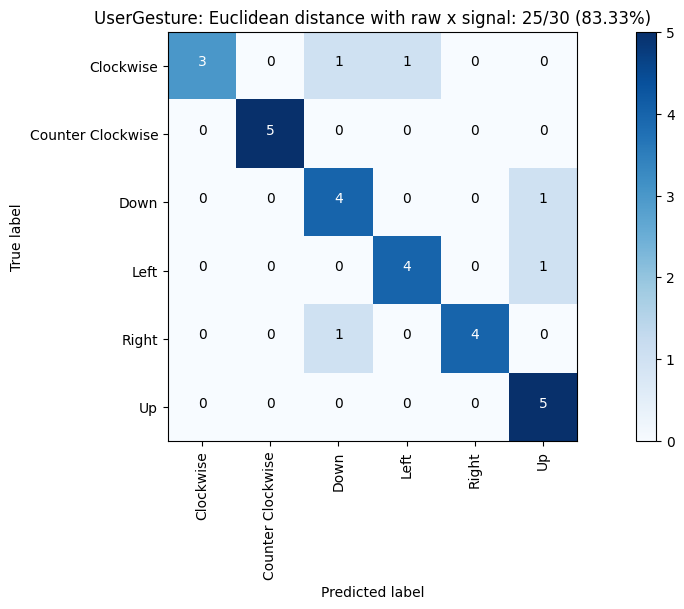

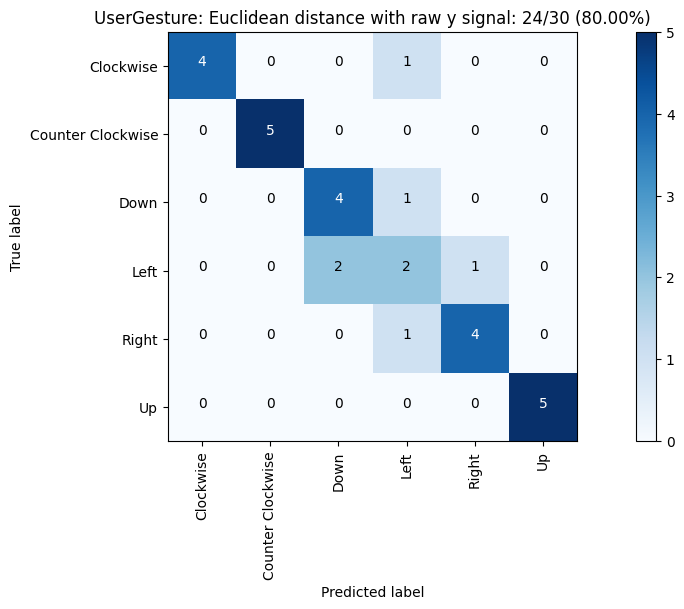

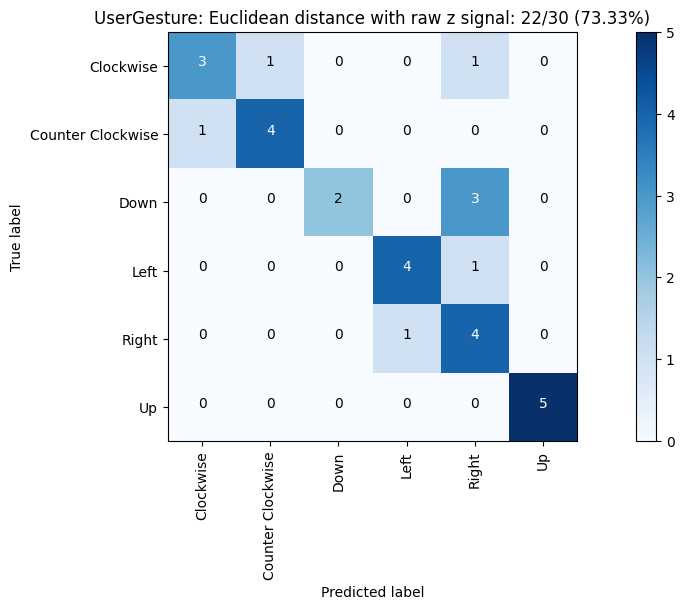

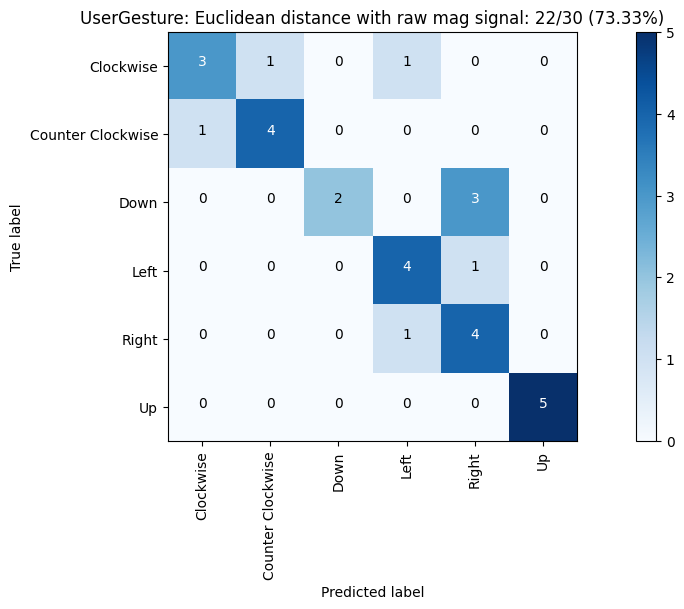

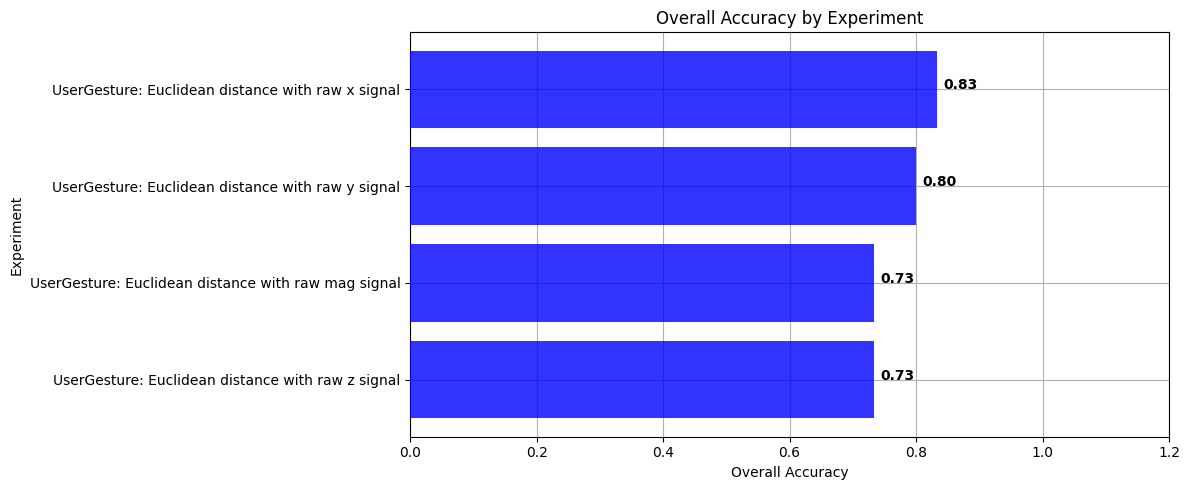

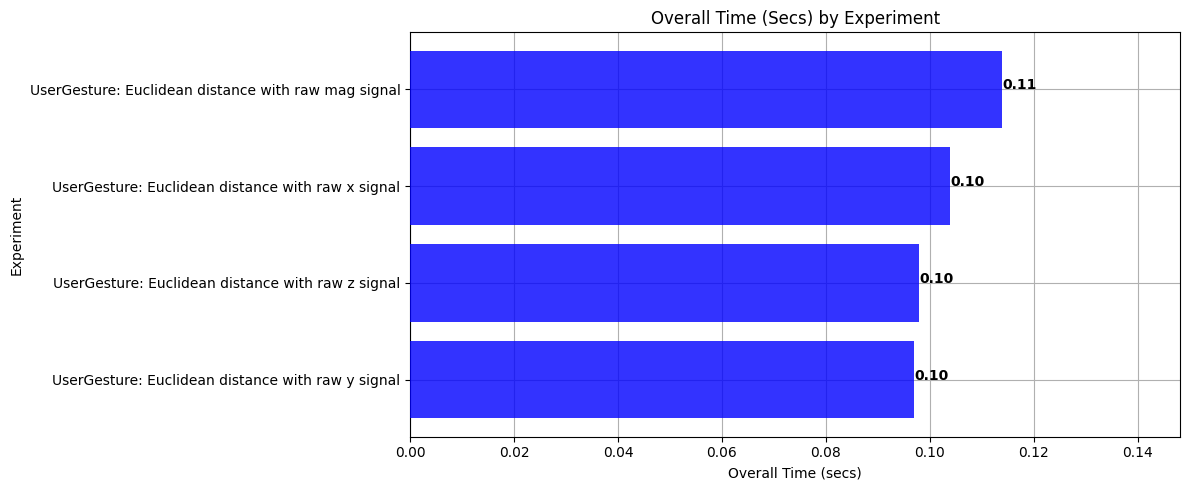

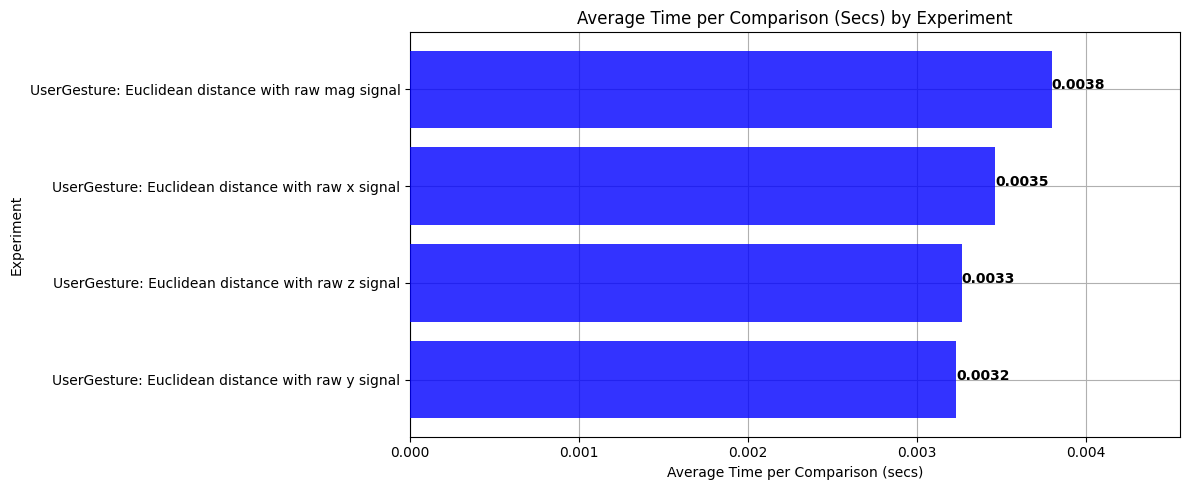

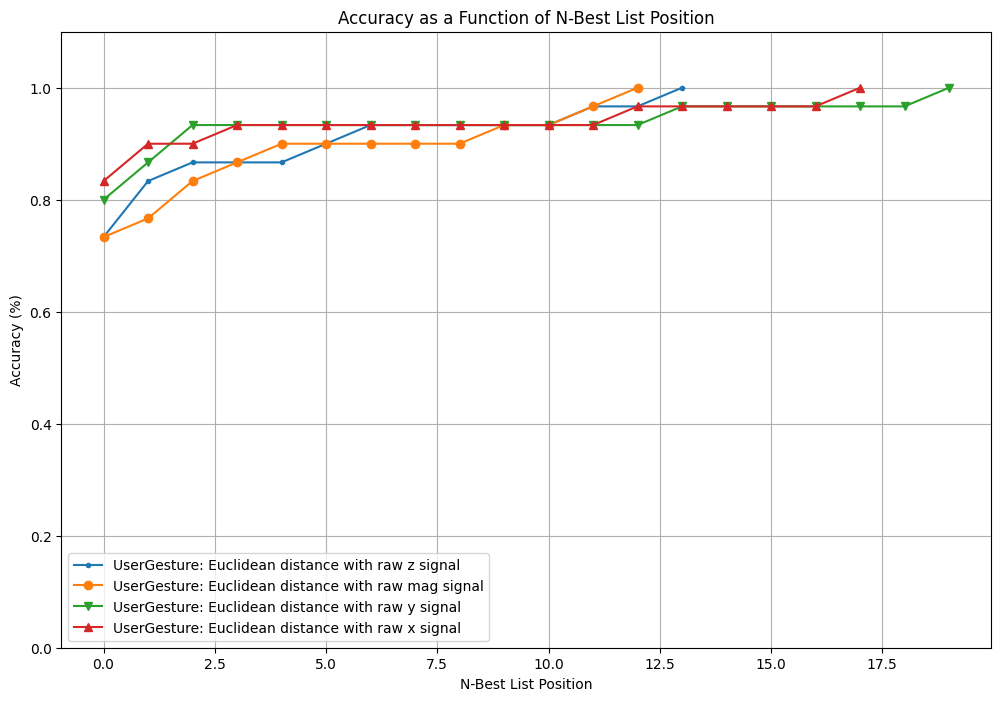

In [20]:
plot_classification_result_as_confusion_matrix(results_x)
plot_classification_result_as_confusion_matrix(results_y)
plot_classification_result_as_confusion_matrix(results_z)
plot_classification_result_as_confusion_matrix(results_mag)
plot_bar_graph_overall_performance(experiments)
plot_bar_graph_overall_time(experiments)
plot_bar_graph_avg_time_per_comparison(experiments)
plot_nbestlist_performance(experiments)

8  Comparing performance across gesture sets


Title: Test10Gesture: Euclidean distance with raw x signal: 25/30 (83.33%)
Optional arguments: {'verbose': False}
Took 0.094s for 30 comparisons (avg=0.003s per match)
- Clockwise 3/5 (60.0%)
- Counter Clockwise 5/5 (100.0%)
- Down 4/5 (80.0%)
- Left 4/5 (80.0%)
- Right 4/5 (80.0%)
- Up 5/5 (100.0%)
[[3 0 1 1 0 0]
 [0 5 0 0 0 0]
 [0 0 4 0 0 1]
 [0 0 0 4 0 1]
 [0 0 1 0 4 0]
 [0 0 0 0 0 5]]

Title: Test1Gesture: Euclidean distance with raw x signal: 25/30 (83.33%)
Optional arguments: {'verbose': False}
Took 0.071s for 30 comparisons (avg=0.002s per match)
- Clockwise 3/5 (60.0%)
- Counter Clockwise 5/5 (100.0%)
- Down 4/5 (80.0%)
- Left 4/5 (80.0%)
- Right 4/5 (80.0%)
- Up 5/5 (100.0%)
[[3 0 1 1 0 0]
 [0 5 0 0 0 0]
 [0 0 4 0 0 1]
 [0 0 0 4 0 1]
 [0 0 1 0 4 0]
 [0 0 0 0 0 5]]

Title: Test2Gesture: Euclidean distance with raw x signal: 25/30 (83.33%)
Optional arguments: {'verbose': False}
Took 0.068s for 30 comparisons (avg=0.002s per match)
- Clockwise 3/5 (60.0%)
- Counter Clockwise 5/5

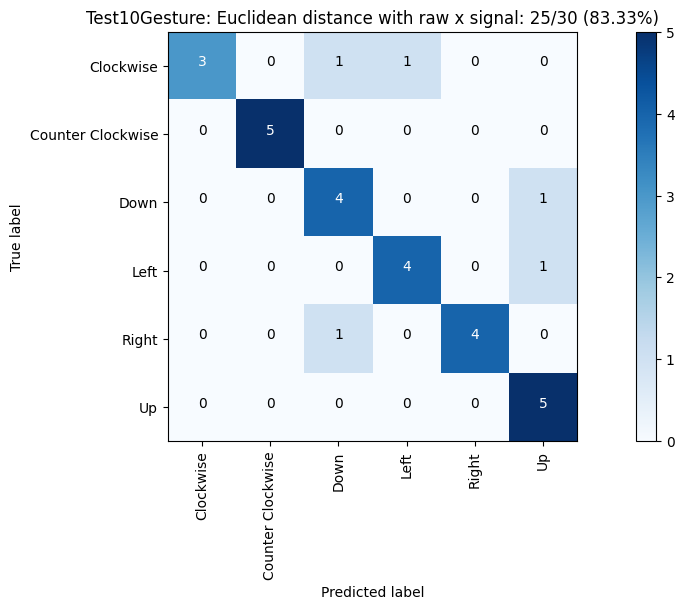

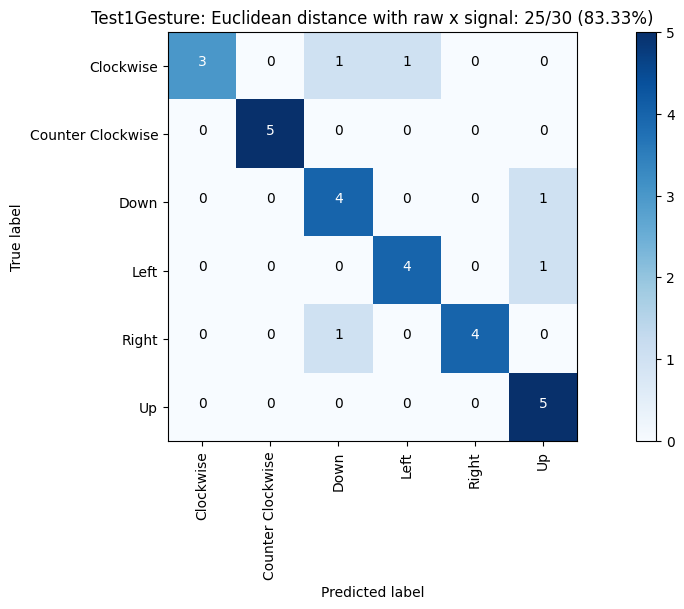

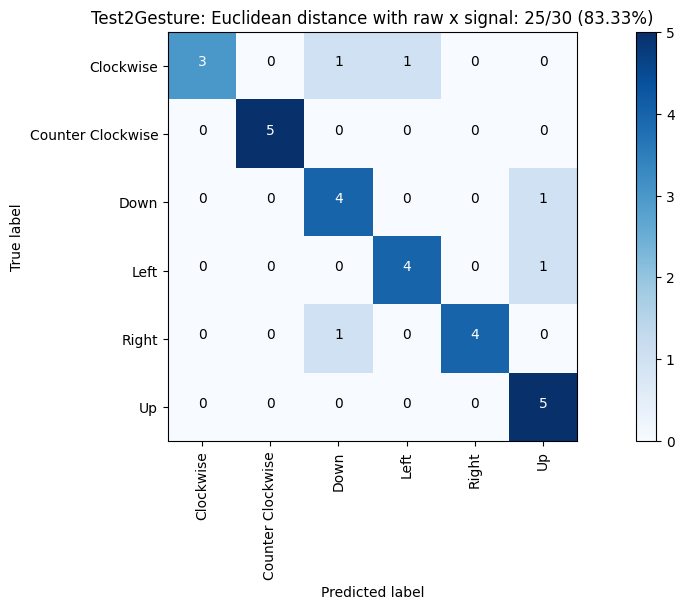

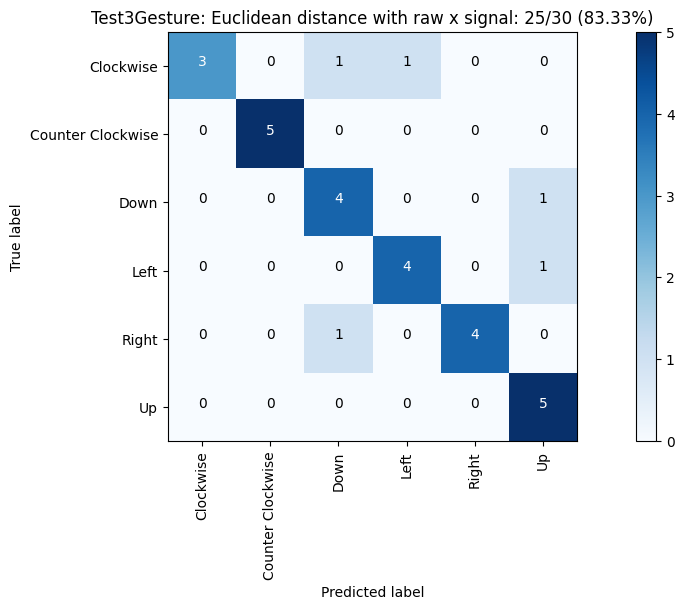

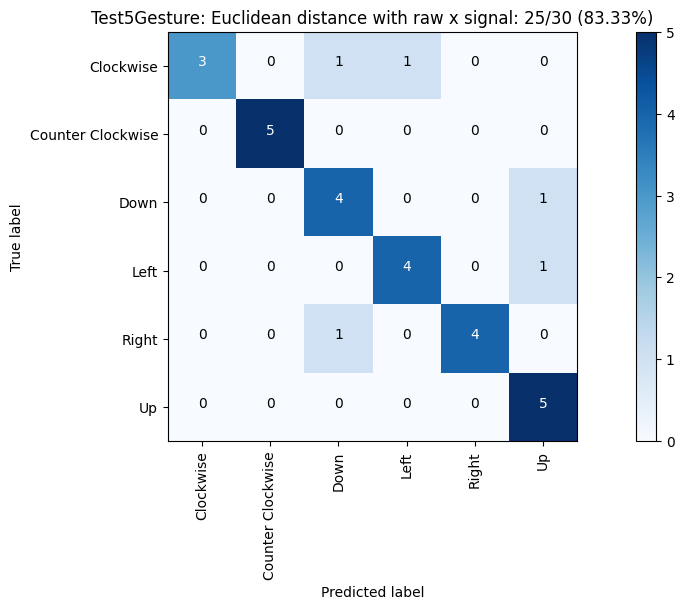

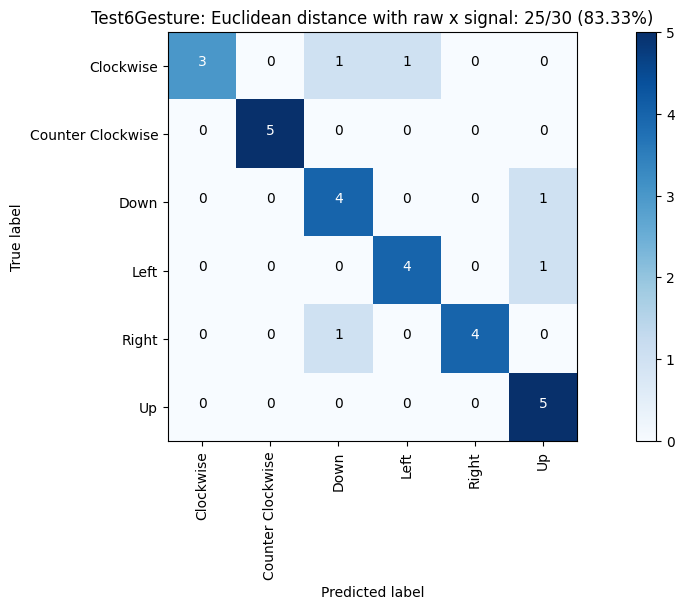

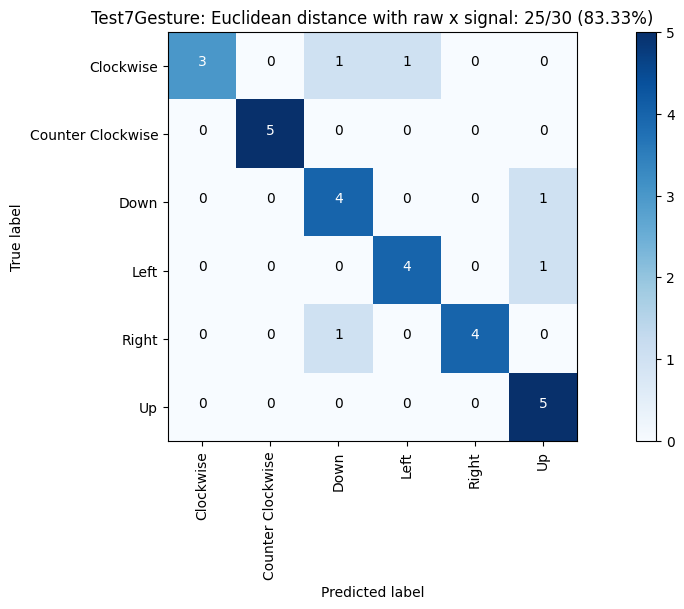

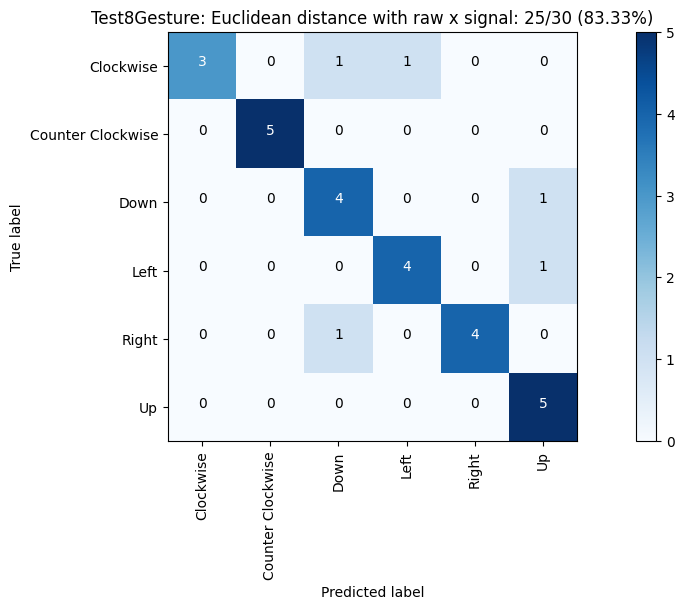

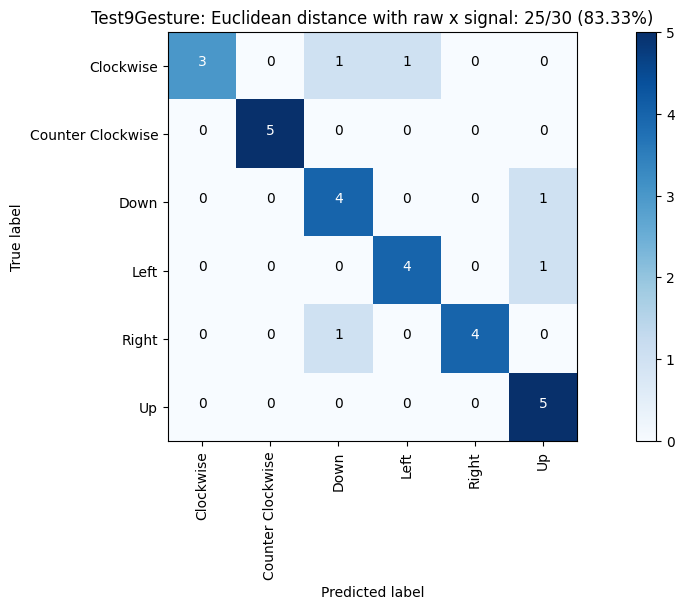

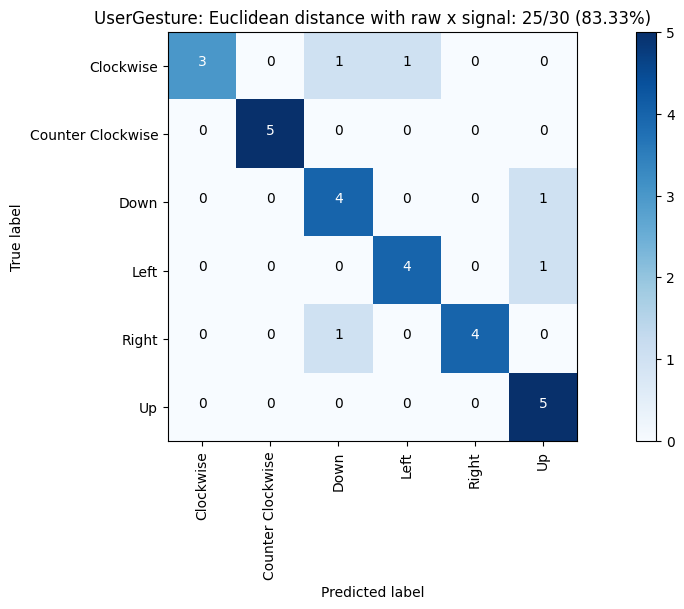

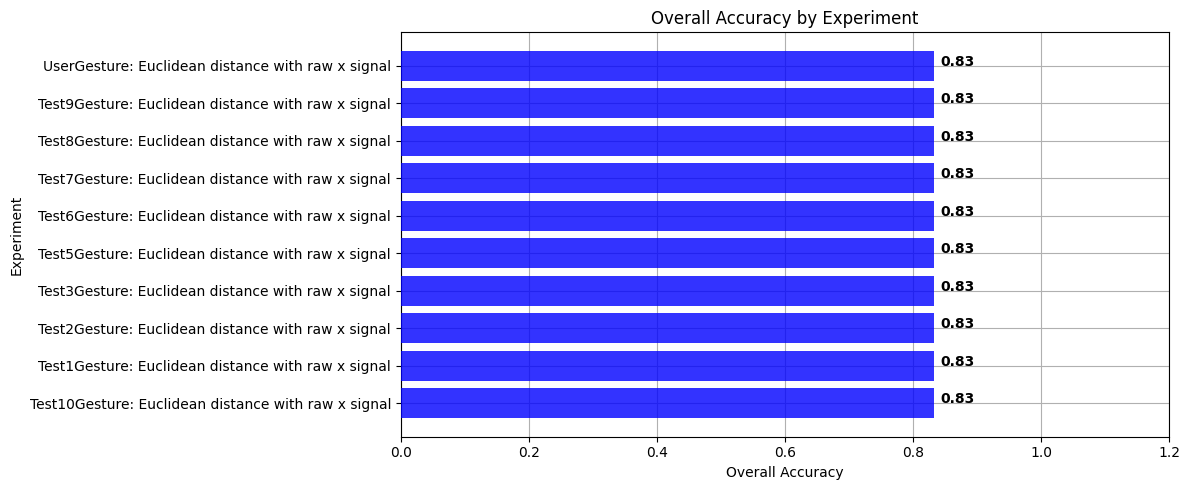

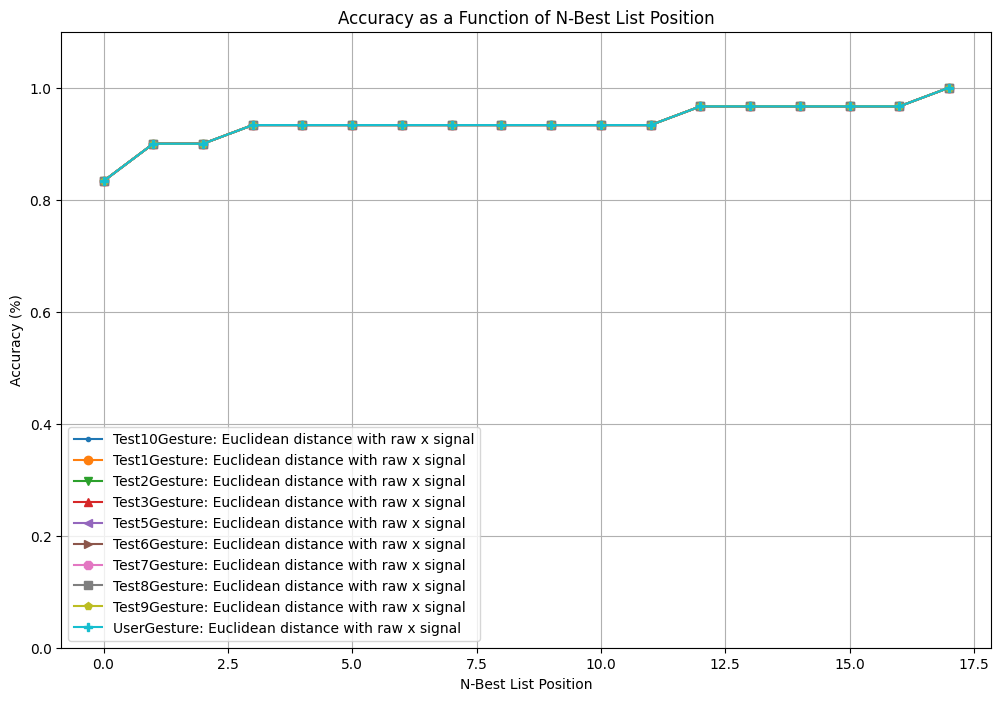

In [16]:
# track multiple experiments
experiments = Experiments()

# Run experiments across all gesture sets
for gesture_set_name, gesture_set in map_gesture_sets.items():
   
    list_folds = generate_kfolds_scikit(5, gesture_set, seed=5)
    
    # run initial experiment
    results = run_matching_algorithm(list_folds, find_closest_match_euclid_raw_x, verbose=False)
    results.title = "{}: Euclidean distance with raw x signal".format(gesture_set.name)
    results.print_result()
    
    plot_classification_result_as_confusion_matrix(results)
    experiments.add(results)

avg_accuracy, stddev = experiments.get_avg_accuracy_with_std()
print(f"Average accuracy: {avg_accuracy} Stdev={stddev}")
plot_bar_graph_overall_performance(experiments)
plot_nbestlist_performance(experiments)

In [17]:
avg_accuracy, stddev = experiments.get_avg_accuracy_with_std()
print(f"Average accuracy: {avg_accuracy} Stdev={stddev}")

Average accuracy: 0.8333333333333334 Stdev=0.0
